In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import dill
import sys
sys.path.append('../')
from modelfitting import train_test_split, ROC_curve, PR_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction

In [2]:
datapath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/training_data/'
dset = 'resonant/'
featurefolder = 'ressummaryfeaturesxgbNorbits10000.0Nout1000/'
features = None

In [3]:
trainingdatafolder = datapath+dset+featurefolder
trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, filter=False)

In [10]:
features = trainX.columns[3:]
trainingdatafolder = datapath+dset+featurefolder
trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, filter=False)

In [12]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 15),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)
def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'], 
                            min_child_weight =space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree =space['colsample_bytree'],
                            learning_rate = space['learning_rate'], seed = 0)
    
    params = clf.get_xgb_params()
    #dtest
    score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    #print score
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    test_score = metrics.roc_auc_score(testY, preds)
    
    print("SCORE:", avg_score, "ERROR", error, "HOLDOUT SCORE", test_score)

    return{'loss':1-test_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error, "holdout":test_score }

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [13]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.92137358                                          
ERROR                                               
0.0055342370948732855                               
HOLDOUT SCORE                                       
0.9399881416765592                                  
SCORE:                                                                       
0.9222509000000001                                                           
ERROR                                                                        
0.00361008558673014                                                          
HOLDOUT SCORE                                                                
0.9378679595955501                                                           
SCORE:                                                                       
0.918412                                                                     
ERROR                                                     

0.0038970544091549973                                                          
HOLDOUT SCORE                                                                  
0.9380915700749634                                                             
SCORE:                                                                         
0.92428148                                                                     
ERROR                                                                          
0.004905368846432323                                                           
HOLDOUT SCORE                                                                  
0.9412582238613286                                                             
SCORE:                                                                         
0.9179031599999998                                                             
ERROR                                                                          
0.004662606402208305                    

ERROR                                                                           
0.005100215991485806                                                            
HOLDOUT SCORE                                                                   
0.9407083827958024                                                              
SCORE:                                                                          
0.92087162                                                                      
ERROR                                                                           
0.004891243395309877                                                            
HOLDOUT SCORE                                                                   
0.939665711835139                                                               
SCORE:                                                                          
0.9204834999999999                                                              
ERROR                       

In [14]:
best

{'x_learning_rate': 0.19935592487785003,
 'x_max_depth': 11,
 'x_min_child': 7.0,
 'x_pos_weight': 13.847472001992983,
 'x_subsample': 0.9550247625914692,
 'x_tree_colsample': 0.6330780598623519}

In [15]:
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])
params = best_xgbc.get_xgb_params()
score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", verbose_eval=True)
print(score)
d_Train = xgb.DMatrix(trainX, trainY)
d_Test = xgb.DMatrix(testX)
bst = xgb.train(params, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print(score)

[0]	train-auc:0.937533+0.00469876	test-auc:0.899268+0.00802703
[1]	train-auc:0.955735+0.00307876	test-auc:0.908981+0.00667753
[2]	train-auc:0.964009+0.00109807	test-auc:0.917286+0.00841177
[3]	train-auc:0.969091+0.00136613	test-auc:0.921772+0.00754298
[4]	train-auc:0.974958+0.00117477	test-auc:0.924647+0.0062599
[5]	train-auc:0.979097+0.00132708	test-auc:0.927727+0.00558295
[6]	train-auc:0.981035+0.00149908	test-auc:0.929526+0.00546978
[7]	train-auc:0.983782+0.00100074	test-auc:0.931187+0.00554188
[8]	train-auc:0.986211+0.00117525	test-auc:0.932918+0.00566483
[9]	train-auc:0.987944+0.00172898	test-auc:0.933805+0.00598538
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.937533       0.004699       0.899268      0.008027
1        0.955735       0.003079       0.908981      0.006678
2        0.964009       0.001098       0.917286      0.008412
3        0.969091       0.001366       0.921772      0.007543
4        0.974958       0.001175       0.924647      0.006260

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


0.8563569479679769


In [16]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

model.fit(trainX, trainY)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6330780598623519, gamma=0,
       learning_rate=0.19935592487785003, max_delta_step=0, max_depth=11,
       min_child_weight=7.0, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=13.847472001992983,
       seed=None, silent=True, subsample=0.9550247625914692)

Text(0.5, 1.0, 'ROC curve (AUC = 0.945)')

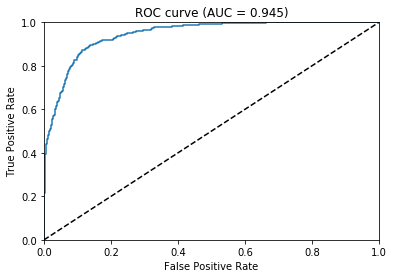

In [17]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [18]:
pr_auc, precision, recall, PRthresholds = PR_curve(trainingdatafolder, model, features)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(PRthresholds[i], recall[i], precision[i]))

Threshold 0.0009182692156173289, recall = 1.0, precision = 0.4006849315068493
Threshold 0.001021147589199245, recall = 0.9978632478632479, precision = 0.40503035559410233
Threshold 0.001123991678468883, recall = 0.9978632478632479, precision = 0.4103690685413005
Threshold 0.0012332415208220482, recall = 0.9978632478632479, precision = 0.41585040071237755
Threshold 0.0012996663572266698, recall = 0.9978632478632479, precision = 0.4214801444043321
Threshold 0.001547131803818047, recall = 0.9978632478632479, precision = 0.4272644098810613
Threshold 0.0017870712326839566, recall = 0.9957264957264957, precision = 0.4322820037105751
Threshold 0.002111967885866761, recall = 0.9957264957264957, precision = 0.43838193791157104
Threshold 0.002336041536182165, recall = 0.9957264957264957, precision = 0.4446564885496183
Threshold 0.0026013620663434267, recall = 0.9957264957264957, precision = 0.45111326234269117
Threshold 0.0029814294539391994, recall = 0.9935897435897436, precision = 0.4567779960

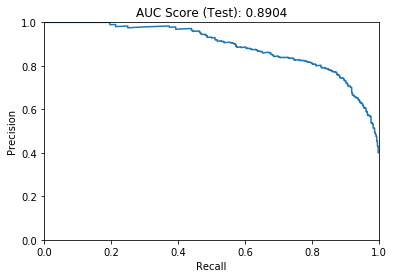

In [19]:
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title("AUC Score (Test): {0:.4f}".format(pr_auc))
plt.show()

(0, 169.4)

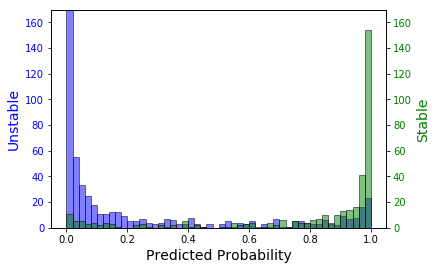

In [20]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
#print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
#print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,1.1*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100

Text(0, 0.5, 'Fraction actually stable')

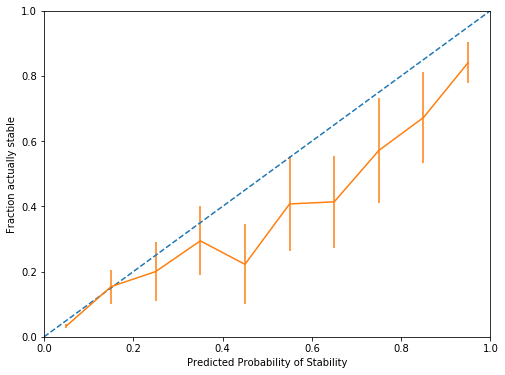

In [21]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

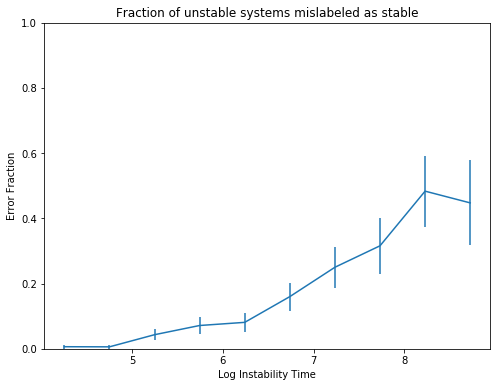

In [22]:
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')

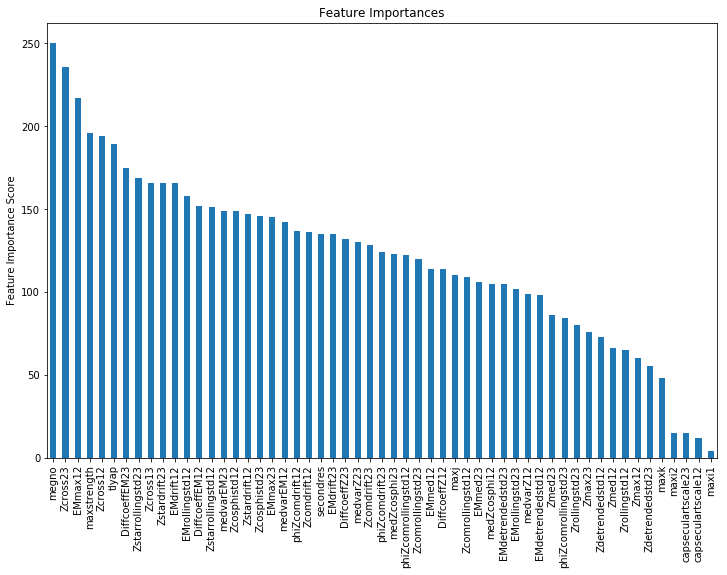

In [23]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

In [18]:
dill.dump([model, features, featurefolder], open(datapath+"../models/ressummaryfeaturesxgb_resonantNoFilter.pkl", "wb"))